# Business Location Explore in Toronto

This is Peer-graded Assignment for Course [Applied Data Science Capstone](https://www.coursera.org/learn/applied-data-science-capstone/home/welcome), Week 4/5





**Contents**

- [1. Introduction](#1) <br>
  - [1.1 Business Requests](#1_1) <br>
  - [1.2 Analytic Approach](#1_2) <br>
 
- [2. Data Collection](#3) <br>
 - [2.1 Scrape location info in Toronto](#21)<br>
 - [2.2 Fetch all 'FOOD' venues in Toronto](#22)<br>
 - [2.3 Show venues on map](#23)<br>
- [3. Methodology](#7) <br> 
 - [3.1 Definition of Sufficiency and InSufficiency](#3_1)<br>
 - [3.2 Isolation Forest Anomaly Dection](#3_2)<br>

- [4. Result](#9) <br> 
- [5. Discussion](#A) <br> 
- [6. Conclusion](#C) <br>







## 1. Introduction　<a id = "1"></a>

### 1.1 Business Requests <a id="1_1"></a>

The location problem has been the challenge for many businesses starts for a long time. Many academic and industrial approaches focus on this problem. In this project we're trying to answer the question, where is the realistic location to start a new business based on existing data. We use Chinese restaurant as the business category to apply machine learning to help investors to make a better decision of location choice in downtown Toronto. 

We assume that an investor wants to start a new business to serve Chinese food in downtown Toronto due to its density of population, higher average income, as well as the diversity of culture. 


### 1.2 Analytic Approach<a id="1_2"></a>

A good location should satisfy the two criteria at the same time:

**(1)** Sufficient demand<br>
**(2)** Insufficient support<br>

To address the first criteria, we could assume that if in some locations exists many restaurants business, there should have a good demand for foodservice in that location.

As per the second criteria, if we could hardly find a Chinese restaurant in the area, then we could say that the support is insufficient.

In summary, we need to gain the data of the food services venue information in the area, as well as their categories.

More specifically, we want to know how many restaurants in specific areas, how many of them provide Chinese food or Asian food.  Based on this information we want to find out the most interesting area which has sufficient demand and insufficient support for Chinese food.

## 2. Data Collection <a id = "3"></a>

Majority we will use data provided by [FourSqare](https://foursquare.com/) to perform our analysis.


FourSquare is a location technology platform to allow developers to fetch the location data, as well as venues information. With the free account one can make 100K calls per day to access their 105M+ points of interest data.

Aiming to the business request described above, we will collect all restrants information in downtown Toronto, and find out their distribution and rating, etc.



### 2.1 Scrape location info in Toronto<a id="21"></a>


We use pandas function read_html to get postal code list in Toronto, as well as the neibourhoods.


In [3]:
import pandas as pd
import numpy as np
import requests
import pickle
import folium
import re 
import uuid

**Step(1)** Fetch postal code in Toronto 

We get the list of postal codes in Toronto from the Wiki page: [List_of_postal_codes_of_Canada](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M), and perform some simple data cleaning job. 

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
dfs = pd.read_html(url)
for idx, df in enumerate(dfs):
    print('DataFrame[{}]:{}'.format(idx, df.shape))

dfs[0].head()    

DataFrame[0]:(180, 3)
DataFrame[1]:(4, 18)
DataFrame[2]:(2, 18)


Postal code           Borough                Neighborhood
0         M1A      Not assigned                         NaN
1         M2A      Not assigned                         NaN
2         M3A        North York                   Parkwoods
3         M4A        North York            Victoria Village
4         M5A  Downtown Toronto  Regent Park / Harbourfront

Oberviously the first data frame is what we need.

Lets remove those 'Not assigned' rows as per column Borough, and check the duplications for Postal Code.

In [3]:
df = dfs[0]
df = df[df['Borough'] != 'Not assigned']
print(df.shape)
len(df['Postal code'].unique())

(103, 3)


103

We are good there's no duplication in column Postal Code.

Chose Postal code as index.

In [4]:
df.set_index('Postal code', inplace=True)
df.head()

Borough                                  Neighborhood
Postal code                                                                
M3A                North York                                     Parkwoods
M4A                North York                              Victoria Village
M5A          Downtown Toronto                    Regent Park / Harbourfront
M6A                North York             Lawrence Manor / Lawrence Heights
M7A          Downtown Toronto  Queen's Park / Ontario Provincial Government

**Step(2)** Attaching geo info for each postal code

We could get geospatial information for each postal code via the online csv file: [Geospatial_data](http://cocl.us/Geospatial_data), then attach it to existing data set.



In [5]:
url = 'http://cocl.us/Geospatial_data'
geo_info = pd.read_csv(url)
geo_info.set_index('Postal Code', inplace=True)
print(geo_info.shape)
geo_info.head()


(103, 2)


Latitude  Longitude
Postal Code                      
M1B          43.806686 -79.194353
M1C          43.784535 -79.160497
M1E          43.763573 -79.188711
M1G          43.770992 -79.216917
M1H          43.773136 -79.239476

Now we can merge these two data set into one.


In [6]:
df = df.merge( geo_info, left_index= True, right_index = True)

df.index.name='Postal Code'
df.head()

Borough                                  Neighborhood  \
Postal Code                                                                   
M3A                North York                                     Parkwoods   
M4A                North York                              Victoria Village   
M5A          Downtown Toronto                    Regent Park / Harbourfront   
M6A                North York             Lawrence Manor / Lawrence Heights   
M7A          Downtown Toronto  Queen's Park / Ontario Provincial Government   

              Latitude  Longitude  
Postal Code                        
M3A          43.753259 -79.329656  
M4A          43.725882 -79.315572  
M5A          43.654260 -79.360636  
M6A          43.718518 -79.464763  
M7A          43.662301 -79.389494

**Step (3)** Visualization areas on map

We can have a general idea of the area by visulize these data on map.


First we get the center point of the map:

In [7]:
lat, lng = df[['Latitude','Longitude']].max() + df[['Latitude','Longitude']].min() 

lat, lng  = lat /2, lng /2 
lat, lng


(43.71926920000001, -79.38815804999999)

Then we can illustrate them on the map:

In [8]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[lat, lng], zoom_start=11)

# add markers to map
for idx, r  in df.iterrows():
    lat, lng, bor, postalcode  =  r['Latitude'], r['Longitude'],r['Borough'], r.name
    label = '{}, {}'.format(bor, postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto


This map clearly shows our research geo scope.

### 2.2 Fetch all 'FOOD' venues in Toronto <a id="22"></a>

In this step we will employee FourSquare API to fetch all venues under category 'FOOD' in Toronto.


**Step(1)** First we set API credentials

In [62]:
#hide this cell while exporting#
api_credentials = {'CLIENT_ID':'Y5FK5TTSXY24B0DDCUJBGCWCL2B01DYMXZRFOXROSYNCSSYJ',
                    'CLIENT_SECRET':'Q4I1XUTLLTDWF1OWT5S0W2H0MZAS3QRJBM1XRA1OEH5E1GVW',
                    'VERSION':'20180605'}
api_credentials

{'CLIENT_ID': 'Y5FK5TTSXY24B0DDCUJBGCWCL2B01DYMXZRFOXROSYNCSSYJ',
 'CLIENT_SECRET': 'Q4I1XUTLLTDWF1OWT5S0W2H0MZAS3QRJBM1XRA1OEH5E1GVW',
 'VERSION': '20180605'}

**Step(2)** Fetch data via FourSquare API

From FourSquare API doc [Venue Categories](https://developer.foursquare.com/docs/build-with-foursquare/categories/), we can tell the following Foursquare Venue Category Hierarchy, as well as their ID.


- Category:
Food: 4d4b7105d754a06374d81259

 - Asian Restaurant: 
4bf58dd8d48988d142941735

   - Chinese Restaurant:
4bf58dd8d48988d145941735


In [63]:
CATEGORYID = '4d4b7105d754a06374d81259'

Due to restriction of max API calls to FourSquares, we save data for future usage.

In [21]:
def dump2file( obj , name = None  ):
    if name is None:
        try:
            name = obj.__name__
        except:
            name = str(uuid.uuid4())
        
    valid_chars_in_filename = '-_.() abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    fn = ''.join(x if x in valid_chars_in_filename else '_' for x in name )
    
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)

def loadFromFile( name  ):
        
    valid_chars_in_filename = '-_.() abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    fn = ''.join(x if x in valid_chars_in_filename else '_' for x in name )
    
    with open(fn, 'rb') as f:
        obj = pickle.load(f)
        
    return obj 

In [220]:
# search venues at specific location 
# Fire API call only when it's not in local files

def venuesbyarea(df = df, radius = 1200 ):
    ret = pd.DataFrame()
    for  idx, area  in df.iterrows():
        
        area_id, name, lng, lat = area['AREA_ID'], area['NAME'], area['LONGITUDE'], area['LATITUDE']

        d = loadFromFile(name)
        
        if not d.empty:
            ret = ret.append( d, ignore_index=True)
            continue 

        url = '{}{}{}{}'.format('https://api.foursquare.com/v2/venues/search?',
              '&client_id={id}&client_secret={pw}&v={v}'.format(id = api_credentials['CLIENT_ID'],
                                                                pw = api_credentials['CLIENT_SECRET'],
                                                                v  = api_credentials['VERSION']),
                '&ll={},{}&radius={}'.format(lat, lng, radius),
                '&categoryId={}'.format(CATEGORYID)              
                )
        print(url)
        try:
            results = requests.get(url).json()
            results = results['response']['venues']
        except Exception  as ex:
            print('Exception on ID:{},lat:{},lng:{}, name:{}, Err:{}'.format(area_id, lat, lng, name, ex))
            print('>>>>results:\n{}\n<<<<<<'.format(results))
            continue

        d = pd.json_normalize(results)
        d['AREA_ID'] = area_id
        for idx, row in d.iterrows():
            for catidx, cat in enumerate(row['categories']):
                if cat['primary']: 
                    d.loc[idx, 'PrimaryCategory'] = cat['name']
                else:
                    d.loc[idx, 'Category-{}'.format(catidx)] = cat['name']

        d.drop(['categories', 'referralId', 'hasPerk', 'location.cc', 'location.crossStreet',
                 'location.labeledLatLngs',
                 'location.city', 'location.state',
                'location.formattedAddress', 
               ], axis =1, errors = 'ignore', inplace=True)
        
        dump2file(d, name)
        ret = ret.append( d, ignore_index=True)
    

    return ret 

Removing duplicated venues by id


In [23]:
venues.drop_duplicates('id', inplace=True)

with open('Venues', 'wb') as f:
    pickle.dump(venues, f)
print(venues.shape)

(2073, 11)


**Step(3)** Review venues contains **Restaurant** in their Name

Lets' foucs on those Restaurants in the venues list, since the stackholder/investor's purpose is to open a restaurnat.


In [24]:
len(venues['PrimaryCategory'].unique())

139

In [25]:
# Find the most frequency categories by Grouping by category and sorting by count desc 
categories_counts = venues[['id','PrimaryCategory']].groupby('PrimaryCategory').count()\
                                                    .sort_values(by='id', ascending=False)

categories_counts.rename({'id':'count'}, axis =1, inplace=True)

categories_counts.head(10)

count
PrimaryCategory            
Coffee Shop             317
Pizza Place             130
Fast Food Restaurant    111
Bakery                   97
Café                     91
Restaurant               88
Chinese Restaurant       81
Grocery Store            65
Sandwich Place           60
Caribbean Restaurant     59

There are lots of categories under **FOOD**, most of them are caffee shop, Pizza Place, even many Grocery Stores are included in the search result. 

Let's focust on those **real** Restaurants.


In [26]:
restaurants = venues[venues['PrimaryCategory'].str.contains('Restaurant')]
restaurants.shape


(884, 11)

Now lets see how many Asian/Chinese Restaurant here:

In [28]:
categories_counts.loc[['Restaurant','Asian Restaurant','Chinese Restaurant']]

count
PrimaryCategory          
Restaurant             88
Asian Restaurant       34
Chinese Restaurant     81

Seems like the category Hierarchy is not well defined.

In [29]:
restaurants_counts = restaurants.groupby('PrimaryCategory').count().sort_values('id', ascending=False)[['id']]
restaurants_counts.rename({'id':'count'}, axis =1, inplace=True)
restaurants_counts.head(10)

count
PrimaryCategory                 
Fast Food Restaurant         111
Restaurant                    88
Chinese Restaurant            81
Caribbean Restaurant          59
Italian Restaurant            54
Middle Eastern Restaurant     41
Indian Restaurant             38
Asian Restaurant              34
Sushi Restaurant              34
Vietnamese Restaurant         32

By reviewing the whole list, we setup a mapping on top of the current category hierarchy. We will use the mapping for further analysis.

In [49]:
AsianRestaurants = ['Asian Restaurant','Burmese Restaurant','Sushi Restaurant', 'Vietnamese Restaurant',
                    'Japanese Restaurant','Korean Restaurant','Thai Restaurant', 
                    'Japanese Curry Restaurant', 'Indian Chinese Restaurant',
                   ]
ChineseRestaurants = ['Chinese Restaurant','Cantonese Restaurant','Hakka Restaurant','Dumpling Restaurant',
                      'Tibetan Restaurant','Taiwanese Restaurant','Udon Restaurant','Shanghai Restaurant',
                      'Hong Kong Restaurant','Hotpot Restaurant',
                     ]


### 2.3 Show venues on map <a id="23"></a>




**Step (1)** Find the center of the map

In [31]:
lat, lng = restaurants[['location.lat','location.lng']].max() + restaurants[['location.lat','location.lng']].min() 
lat, lng  = lat /2, lng /2 
lat, lng

(43.706925113970044, -79.38951799620264)

**Step (2)** Mark the venues on maps

We use three colors in the visulization:
- <span style="color:red">Red</span>: Chinese Restaurants
- <span style="color:blue">Blue</span>: Asian Restaurants, excluding Chinese Restaurants
- <span style="color:green">Green</span>: All other restaurants

In [32]:
# create map of New York using latitude and longitude values
map_all_venues = folium.Map(location=[lat, lng], zoom_start=11)

# add markers to map
for idx, r  in restaurants.iterrows():
    lat, lng, name, category =  r['location.lat'], r['location.lng'],r['name'], r['PrimaryCategory']
    if category in ChineseRestaurants:
        color = 'red'
    elif category in AsianRestaurants:
        color = 'blue'
    else:
        color = 'green'
    
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color= color, #'#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_all_venues)  
    
map_all_venues


## 3. Methodology  <a id = "7"></a>

In this part we will employee *** to analysis the data, to find out the area which satisfies:

(1) Sufficient demand <br>
(2) Insufficient support<br>

We define a 'Sufficient Demand' as a bigger average restaurant provider over the neighborhood area, and 'Insufficient Support' as a smaller average restaurant business over the area. 

Since most business opportunities arise in system edge, like optimization value is always on the boundary of the scope, we employed **Anomaly** Detection model using **Isolation Forest** in Python library scikit-learn.



### 3.1 Definition of Sufficiency and InSufficiency <a id="3_1"></a>


**Step(1)** Get Area info


From City of Toronto [Open Data Portol](https://www.toronto.ca/city-government/data-research-maps/open-data/) we can get all neibourhood boundary, area we can calculate the average food service provider over area.


In [68]:
url='https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15?format=geojson&projection=4326'
r = requests.get(url).json()
pd.json_normalize(r['features']).head()

cols =  ['properties._id','properties.AREA_SHORT_CODE', 'properties.AREA_NAME', 'properties.Shape__Area',
        'properties.LATITUDE',    'properties.LONGITUDE',   ]
df = pd.json_normalize(r['features'])[cols]
df.columns = ['AREA_ID','CODE', 'NAME', 'AREA', 'LATITUDE', 'LONGITUDE'   ]
print(df.shape)
df.head()

(140, 6)


AREA_ID  CODE                          NAME          AREA   LATITUDE  \
0     4621    94                 Wychwood (94)  3.217960e+06  43.676919   
1     4622   100          Yonge-Eglinton (100)  3.160334e+06  43.704689   
2     4623    97           Yonge-St.Clair (97)  2.222464e+06  43.687859   
3     4624    27  York University Heights (27)  2.541821e+07  43.765736   
4     4625    31       Yorkdale-Glen Park (31)  1.156669e+07  43.714672   

   LONGITUDE  
0 -79.425515  
1 -79.403590  
2 -79.397871  
3 -79.488883  
4 -79.457108

**Step (2)** Aggregation restaurants 

Now we count the restaurants in each area, as per pre defined categories.

In [222]:
restaurnatsByArea = venuesByArea[ venuesByArea['PrimaryCategory'].str.contains('Restaurant')]
restaurnatsByArea.shape

AsianR_ExCN = restaurnatsByArea.apply(lambda x: 1 if x['PrimaryCategory'] in AsianRestaurants else 0, axis=1)
ChineseR = restaurnatsByArea.apply(lambda x: 1 if x['PrimaryCategory'] in ChineseRestaurants else 0, axis=1)
OtherR = restaurnatsByArea.apply(lambda x: 0 if x['PrimaryCategory'] in ChineseRestaurants or \
                                                x['PrimaryCategory'] in AsianRestaurants else 1, axis=1)

df_grp  = pd.DataFrame({'AREA_ID':restaurnatsByArea['AREA_ID'], 
                        'ChineseR':ChineseR, 
                        'AsianR_ExCN':AsianR_ExCN, 
                        'OtherR':OtherR,
                        'AnyR': 1})
df_grp.shape

df_grp = df_grp.groupby('AREA_ID').sum().merge(df, left_index=True, right_on ='AREA_ID', how='outer')
df_grp.fillna(0, inplace=True)
print(df_grp.shape)
df_grp.head()

(140, 10)


ChineseR  AsianR_ExCN  OtherR  AnyR  AREA_ID  CODE  \
0       0.0          1.0     5.0   6.0     4621    94   
1       0.0          0.0     3.0   3.0     4622   100   
2       0.0          1.0    11.0  12.0     4623    97   
3       1.0          3.0     7.0  11.0     4624    27   
4       0.0          4.0    11.0  15.0     4625    31   

                           NAME          AREA   LATITUDE  LONGITUDE  
0                 Wychwood (94)  3.217960e+06  43.676919 -79.425515  
1          Yonge-Eglinton (100)  3.160334e+06  43.704689 -79.403590  
2           Yonge-St.Clair (97)  2.222464e+06  43.687859 -79.397871  
3  York University Heights (27)  2.541821e+07  43.765736 -79.488883  
4       Yorkdale-Glen Park (31)  1.156669e+07  43.714672 -79.457108

**Step (3)** Calculating the Average value

Now we have count of restaurants, and size of the area, we can calculate the density of existing business.

To enlarge the distribution, we apply log to the mean value.

In [223]:
Avg_AsianR = df_grp.apply(lambda x: np.log( 1 + x['AsianR_ExCN'] / (1 + x['AREA']) * 1e7 ), axis=1)
Avg_ChineseR = df_grp.apply(lambda x: np.log( 1 + x['ChineseR'] / (1 + x['AREA']) * 1e7 ), axis=1)
Avg_OtherR = df_grp.apply(lambda x: np.log( 1 + x['OtherR'] / (1 + x['AREA']) * 1e7 ), axis=1)
Avg_AnyR = df_grp.apply(lambda x: np.log( 1 + x['AnyR'] / (1 + x['AREA']) * 1e7 ), axis=1)


df_avg  = pd.DataFrame({'AREA_ID':df_grp['AREA_ID'], 
                      'Avg_ChineseR':Avg_ChineseR, 
                      'Avg_AsianR':Avg_AsianR, 
                      'Avg_OtherR':Avg_OtherR,
                       'Avg_AnyR':Avg_AnyR })
print(df_avg.shape)

df_avg.head()

(140, 5)


AREA_ID  Avg_ChineseR  Avg_AsianR  Avg_OtherR  Avg_AnyR
0     4621       0.00000    1.412829    2.805648  2.977841
1     4622       0.00000    0.000000    2.350676  2.350676
2     4623       0.00000    1.704659    3.921866  4.007226
3     4624       0.33176    0.779442    1.322804  1.672902
4     4625       0.00000    1.494747    2.352334  2.636789

**Step (4)** distribution of the mean values 

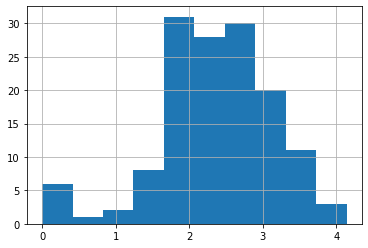

In [224]:
df_avg['Avg_AnyR'].hist();


### 3.2 Isolation Forest Anomaly Detection <a id="3_2"></a>

As you might expect from the name, Isolation Forest instead works by isolating anomalies explicitly isolating anomalous points in the dataset.

Most business opportunities exist in those edge points, which drove us to apply the Isolation Forest Anomaly Detection model to find those specific opportunities.

**Step (1)** Define and Fit the model 

We only consider the mean values in our model.

In [167]:
IF_cols = ['Avg_ChineseR','Avg_AsianR','Avg_OtherR','Avg_AnyR']

In [166]:
model=IsolationForest( n_estimators=50, max_samples='auto', contamination=float(0.1), max_features=4 )
model.fit( df_avg[])

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.1,
                max_features=4, max_samples='auto', n_estimators=50,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

Now we have the model tained successfully. 

**Step (2)** Attached Scores and Anomaly Column 

Let's find the scores and anomaly status for each sample. We can get this information by calling **decision_function()** of the above model and passing the four mean values as parameters.

Also, we can get the values of anomaly status by calling the **predict()** function of the above model and using the four mean values as parameters.


In [179]:
result_cols = ['AREA_ID', 'scores','anomaly', 'NAME', 'LATITUDE','LONGITUDE' ]
df_avg['scores'] = model.decision_function(df_avg[IF_cols])
df_avg['anomaly']=model.predict(df_avg[IF_cols])
df_result = df_avg.merge( df )[result_cols]
df_result.sort_values('scores', inplace=True)

In [180]:
df_result

AREA_ID    scores  anomaly                      NAME   LATITUDE  \
27      4649 -0.118717       -1  North St.James Town (74)  43.669623   
37      4660 -0.115751       -1          Regent Park (72)  43.659992   
2       4623 -0.079746       -1       Yonge-St.Clair (97)  43.687859   
42      4665 -0.065879       -1               Rouge (131)  43.821201   
40      4663 -0.055065       -1         Roncesvalles (86)  43.646123   
..       ...       ...      ...                       ...        ...   
24      4646  0.173633        1     Newtonbrook West (36)  43.785830   
113     4739  0.174701        1   Forest Hill South (101)  43.694526   
39      4662  0.177534        1   Rockcliffe-Smythe (111)  43.674790   
41      4664  0.180706        1  Rosedale-Moore Park (98)  43.682820   
9       4630  0.181015        1   Leaside-Bennington (56)  43.703797   

     LONGITUDE  
27  -79.375247  
37  -79.360509  
2   -79.397871  
42  -79.186343  
40  -79.442992  
..         ...  
24  -79.431422  
113 -79.414318  
39  -79.494420  
41  -79.379669  
9   -79.366072  

[140 rows x 6 columns]

**Step (3)** Visulization the result

We can use the hist char to visulize the scores of model result.

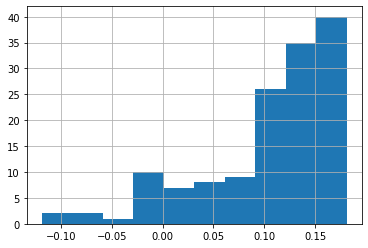

In [225]:
df_result['scores'].hist();

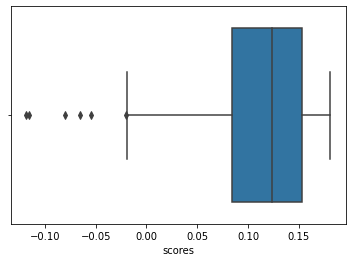

In [236]:
sns.boxplot(df_result['scores']);

We can tell that the anomaly exists on the very left side.


**Step (4)** Visualization on map

For better impact, we put the model result on the map, which will give our stakeholders a better understanding of the **data-driven** approach.

We added **Three** Layers on top of the geo map:
- Choropleth maps, to tell the density of restaurants
- Circle Markers, to plot all restaurants plus categories
- Leaflet Markers, to flag the two anomalies location


In [240]:
lat, lng = venuesByArea[['location.lat','location.lng']].min() + venuesByArea[['location.lat','location.lng']].max()
lat, lng = lat/2, lng/2 
m = folium.Map( location = [lat, lng], zoom_start = 11)

# Choropleth maps, to tell the density of resterauants
folium.Choropleth(
    geo_data = url, 
    name='choropleth',
    data= df_avg,    columns=('AREA_ID', 'Avg_AnyR'),
    key_on='feature.properties._id',
    fill_color= 'YlGnBu', #'YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Restarunt Density'
).add_to(m)

#Circle Markers, to plot all restaurants plus categories
for idx, r  in restaurnatsByArea.iterrows():
    lat, lng, name, category =  r['location.lat'], r['location.lng'],r['name'], r['PrimaryCategory']
    if category in ChineseRestaurants:
        color = 'red'
    elif category in AsianRestaurants:
        color = 'blue'
    else:
        color = 'green'
    
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color=color,
        fill=True,
        fill_color= color,
        fill_opacity=0.7,
        parse_html=False).add_to(m)  
       
# Leaflet Markers, to flag the two anomalies location
for idx, r  in df_result[df_result['scores'] <= -0.05].iterrows():
    lat, lng, name, score, =  r['LATITUDE'], r['LONGITUDE'],r['NAME'], r['scores']
    
    label = '{}\nScore:{:.2f}'.format(name, score)
    color = 'red' if score <= -0.1 else 'orange'
    
    folium.Marker(
        [lat, lng],
        radius=5,
        popup=label,
        icon=folium.Icon(color=color, icon='info-sign')
        ).add_to(m)  
       
   

folium.LayerControl().add_to(m)

m

## 4. Result  <a id = "9"></a>

To open a new Chinese restaurant, we have two locations with potentially highest opportunites, marked as <span style="color:red"> Red </span> on above map:<br>
- North St.James Town  <br>
- Regent Park <br>


Plus the other three locations may also have moderate oppertunites, marked as  <span style="color:orange"> Orange </span> on above map: <br>
- Yonge-St.Clair<br>
- Rouge <br>
- Roncesvalles<br>



In [245]:
df_grp[df_grp['AREA_ID'].isin([4649,4660,4623, 4665, 4663])]\
      [['NAME','AREA','ChineseR','AsianR_ExCN','OtherR','AnyR']]

NAME          AREA  ChineseR  AsianR_ExCN  OtherR  \
2        Yonge-St.Clair (97)  2.222464e+06       0.0          1.0    11.0   
28  North St.James Town (74)  8.113039e+05       1.0          1.0     3.0   
39          Regent Park (72)  1.243326e+06       1.0          0.0     6.0   
42         Roncesvalles (86)  2.875399e+06       0.0          1.0     0.0   
44               Rouge (131)  7.214402e+07       0.0          1.0     5.0   

    AnyR  
2   12.0  
28   5.0  
39   7.0  
42   1.0  
44   6.0

## 5. Discussion <a id = "A"></a>

We could add more features into the model, such as the rating of the venues, size of the business, etc. 

Also, it would be better if we could fetch more data from different data sources, along with FourQuares, it may help us to build a more accurate model.

Plus, We could introduce other dimensional data like population, Demographics, income, etc., for this information also has an impact on the consuming market.


## 6. Conclusion <a id = "C"></a>

Since many believe that business opportunities most-likely happen in an abnormal scenario, we employed the Isolation Forest model to find outliers in the restaurant business, and find out location-based significantly different from those majority of the other locations.
